**2021.06.03 購肥農地籍比對**

亭君的說明 on [clickup](https://sharing.clickup.com/t/h/91wy0e/OC7YPYEK2W9LLU4)
- 要清理的資料：舊農識系統匯出的農民與農地資料(2021/5/13)
- 比對資料來源 (農委會的地籍系統): 農委會地籍資料-僅農牧用地(版本:109Dec)
    - 註1: [欄位名稱](https://drive.google.com/file/d/1n5fJwcaxgEXrAwjA0W9pMwqJltymLZbj/view)、[代碼對照表](https://docs.google.com/spreadsheets/d/1myjAgbzqQhul3BK5LmycNzQCR0BgDskg/edit#gid=1896828860)
    - 註2: 登記面積是"平方公尺"，農識系統的面積都是"公頃" 
    - 單位換算: 1平方公尺=0.0001公頃
- 比對的條件
    - FullLandNo正確 且 舊系統的面積小於等於農委會的即可
    - 若FullLandNo無法對應，則進一步比對縣市、鄉鎮、地段、地號 (篩出有問題的地籍)
- 無法對應的FullLandNo可能有以下類型
    1. 非農牧用地
        - 處理方式：去農委會GIS地籍系統下載其他非農牧用地的地籍
            - (問題1: 地籍系統被入侵目前關閉中)
            - (問題2: 農委會不願意一次提供全部的地籍，需要分縣市或分條件下載)
    2. 河川地
        - 處理方式：因為農委會地籍系統中沒有河川地籍，要另外比對河川局提供的地籍清單 
            - (問題1: 河川局沒有FullLandNo，農識系統中的FullLandNo是農識工程師自己編的 😞 )
                - 可嘗試：6/3在農識系統找到原本的河川地地號(尚未被農識工程師污染的形式)，或許可嘗試比對 
    3. 舊版的地籍資料
        - 處理方式：不確定農委會是否有提供新舊版地籍比對功能？(先擱置)
    4. 未知因素導致的地籍錯誤
        - 處理方式：先看數量有多少，再跟農糧署承辦討論是否將這些不合格的資料全部捨棄(?)，或「將錯就錯」直接認列(?)

In [1]:
import pandas as pd
import numpy as np
import re
from polib.CsvEngn import *

# 資料匯入

## 舊農地購肥資料

In [17]:
# old_path = r"G:\我的雲端硬碟\work\2021\99.其他交辦\7.農地籍比對\農民農地資料_20210513(解鎖).xlsx"
# old_df = pd.read_excel(old_path, sheet_name="Rawdata")

# # 轉存 pkl
# formtoPkl(old_df, "old_農民農地資料_20210513")

 >>> 建立今天的工作區: 0604
 ==輸出備份pkl== ::: old_農民農地資料_20210513_20210604_09.11.05.pkl


In [2]:
# 讀檔
old_pkl_path = r"G:\我的雲端硬碟\python\output\0604\old_農民農地資料_20210513_20210604_09.11.05.pkl"
old_df = read_data_dir_fPathExt(old_pkl_path)
old_df.info()

  >> 讀取:: G:\我的雲端硬碟\python\output\0604\old_農民農地資料_20210513_20210604_09.11.05.pkl
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802228 entries, 0 to 802227
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   欄位1             802225 non-null  float64
 1   欄位2             802225 non-null  float64
 2   欄位3             802225 non-null  float64
 3   FarmerIDCardNo  802228 non-null  object 
 4   CountyName      802225 non-null  object 
 5   TownshipName    802225 non-null  object 
 6   TownshipCode    802222 non-null  float64
 7   CountyCode      802225 non-null  object 
 8   Section         802225 non-null  object 
 9   Code            802225 non-null  object 
 10  LandNo          802225 non-null  object 
 11  RegArea         802225 non-null  object 
 12  FullLandNo      802225 non-null  object 
 13  CreateDate      802225 non-null  object 
 14  UpdateDate      802225 non-null  object 
 15  UserIP          77906

In [3]:
# 檢查 FullLandNo、RegArea 缺值數量
print(f">> FullLandNo 缺值數量: {old_df.FullLandNo.isna().sum()}")
print(f">> RegArea 缺值數量: {old_df.RegArea.isna().sum()}")

>> FullLandNo 缺值數量: 3
>> RegArea 缺值數量: 3


In [4]:
# 檢查 FullLandNo 是否皆符合: (農地) 前2大寫英 後12數字 的規則 or (河川地) 前2大寫英 後5數字 1大寫R 後7數字 的規則
FullLandNo_pattern_farm = re.compile("^[A-Z]{2}\d{12}")
FullLandNo_pattern_river = re.compile("^[A-Z]{2}\d{5}R\d{7}")

#貼標
old_df.loc[:, "is_FullLandNo_pattern_farm"] = old_df.FullLandNo.str.match(FullLandNo_pattern_farm)
print(f">> 符合農地條件的FullLandNo數量:\n{old_df.loc[:, 'is_FullLandNo_pattern_farm'].value_counts()}\n")

old_df.loc[:, "is_FullLandNo_pattern_river"] = old_df.FullLandNo.str.match(FullLandNo_pattern_river)
print(f">> 符合河川條件的FullLandNo數量:\n{old_df.loc[:, 'is_FullLandNo_pattern_river'].value_counts()}\n")

# 是農地或河川地
old_df.loc[:, "is_FullLandNo_pattern_OK"] = old_df.loc[:, "is_FullLandNo_pattern_farm"] | old_df.loc[:, "is_FullLandNo_pattern_river"]
print(f">> 符合農地或河川條件的FullLandNo數量:\n{old_df.loc[:, 'is_FullLandNo_pattern_OK'].value_counts()}\n")

>> 符合農地條件的FullLandNo數量:
True     795017
False      7208
Name: is_FullLandNo_pattern_farm, dtype: int64

>> 符合河川條件的FullLandNo數量:
False    795343
True       6882
Name: is_FullLandNo_pattern_river, dtype: int64

>> 符合農地或河川條件的FullLandNo數量:
True     801899
False       329
Name: is_FullLandNo_pattern_OK, dtype: int64



In [1]:
# old_df[old_df["is_FullLandNo_pattern_OK"].isin([False])].head(3)

In [5]:
# 檢查 RegArea 格式
old_df.loc[:,"RegArea_number"] = pd.to_numeric(old_df.loc[:,"RegArea"],errors='coerce')
print(f">> RegArea 無法轉換成數值的數量: {old_df.loc[:,'RegArea_number'].isna().sum()}")
#貼標
old_df.rename(columns={"RegArea":"RegArea_org", "RegArea_number":"RegArea"}, inplace=True)
old_df.loc[:,"is_RegArea_OK"] = old_df.loc[:,'RegArea'].notna()

>> RegArea 無法轉換成數值的數量: 6


In [6]:
# 挑出 FullLandNo、RegArea 都正常的資料做下一步比對
mask_OK = ((old_df.loc[:, "is_FullLandNo_pattern_OK"].isin([True])) & (old_df.loc[:, "is_RegArea_OK"].isin([True])))
print(f">> old_df 符合規則的 資料筆數: {len(old_df[mask_OK])}")

>> old_df 符合規則的 資料筆數: 801899


## 109年農牧地籍資料

In [7]:
new_df_column_name = [
  'OID'
  ,'宗地母號'
  ,'宗地子號'
  ,'段碼'
  ,'段延伸碼'
  ,'段號'
  ,'地號'
  ,'登記日期'
  ,'地目碼'
  ,'等則碼'
  ,'登記面積_平方公尺'
  ,'使用分區碼'
  ,'使用類別碼'
  ,'縣市碼'
  ,'鄉鎮碼'
  ,'段小段碼'
  ,'使用分區'
  ,'使用類別'
  ,'地目'
  ,'段'
  ,'小段'
  ,'縣市'
  ,'鄉鎮'
  ,'Shape_Length'
  ,'Shape_Area'
]

In [7]:
# new_path = r"G:\我的雲端硬碟\work\2021\99.其他交辦\7.農地籍比對\GPL0_農牧用地_109Dec.csv"
# new_df = pd.read_csv(new_path, header=None, prefix="col_", skiprows=1)
# new_df.columns =  new_df_column_name

# # 轉存 pkl
# formtoPkl(new_df, "new_GPL0_農牧用地_109Dec")

 ==輸出備份pkl== ::: new_GPL0_農牧用地_109Dec_20210604_14.33.54.pkl


In [7]:
# 讀檔
new_pkl_path = r"G:\我的雲端硬碟\python\output\0604\new_GPL0_農牧用地_109Dec_20210604_14.33.54.pkl"
new_df = read_data_dir_fPathExt(new_pkl_path)
print(f">> new_df 資料筆數: {len(new_df)}")

  >> 讀取:: G:\我的雲端硬碟\python\output\0604\new_GPL0_農牧用地_109Dec_20210604_14.33.54.pkl
>> new_df 資料筆數: 2995079


In [10]:
new_df.rename(columns={"段號":"FullLandNo", "登記面積_平方公尺":"RegArea_m2"}, inplace=True)

new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995079 entries, 0 to 2995078
Data columns (total 25 columns):
 #   Column        Dtype  
---  ------        -----  
 0   OID           int64  
 1   宗地母號          int64  
 2   宗地子號          int64  
 3   段碼            int64  
 4   段延伸碼          object 
 5   FullLandNo    object 
 6   地號            int64  
 7   登記日期          object 
 8   地目碼           object 
 9   等則碼           object 
 10  RegArea_m2    float64
 11  使用分區碼         object 
 12  使用類別碼         object 
 13  縣市碼           object 
 14  鄉鎮碼           int64  
 15  段小段碼          object 
 16  使用分區          object 
 17  使用類別          object 
 18  地目            object 
 19  段             object 
 20  小段            object 
 21  縣市            object 
 22  鄉鎮            object 
 23  Shape_Length  float64
 24  Shape_Area    float64
dtypes: float64(3), int64(6), object(16)
memory usage: 571.3+ MB


In [11]:
# 檢查是否有完全重複的 row
new_nodup_df = new_df.drop_duplicates(keep="first")
print(f">> new_df 完全重複的row數: {len(new_df)-len(new_nodup_df)}")

>> new_df 完全重複的row數: 0


In [12]:
# 檢查 FullLandNo、RegArea 缺值數量
print(f">> FullLandNo 缺值數量: {new_df.FullLandNo.isna().sum()}")
print(f">> RegArea_m2 缺值數量: {new_df.RegArea_m2.isna().sum()}")

>> FullLandNo 缺值數量: 0
>> RegArea_m2 缺值數量: 0


In [13]:
# RegArea 單位轉換 (1平方公尺=0.0001公頃)
new_df.loc[:,"RegArea"] = (new_df.loc[:,"RegArea_m2"] * 0.0001).round(4)

In [14]:
# 檢查 FullLandNo 是否皆符合: (農地) 前2大寫英 後12數字 的規則
new_df.loc[:, "is_FullLandNo_pattern_farm"] = new_df.FullLandNo.str.match(FullLandNo_pattern_farm)
new_df.loc[:, "is_FullLandNo_pattern_farm"].value_counts()

True    2995079
Name: is_FullLandNo_pattern_farm, dtype: int64

In [15]:
# 檢查 FullLandNo、RegArea  是否 唯一對應
new_FullLandNo_count_RegArea = new_df[["FullLandNo","RegArea"]].drop_duplicates(
                                                                keep="first").groupby(
                                                                    "FullLandNo", as_index=False).count()
new_FullLandNo_count_RegArea[new_FullLandNo_count_RegArea.RegArea>1]
print(">>  FullLandNo、RegArea  皆唯一對應")

>>  FullLandNo、RegArea  皆唯一對應


In [16]:
# 製作 比對字典 key: FullLandNo, value:RegArea
new_match_dict = pd.Series(new_df.RegArea.values, index=new_df.FullLandNo).to_dict()
# new_match_dict

## 河川地籍資料

In [17]:
river_path = r"G:\我的雲端硬碟\work\2021\99.其他交辦\7.農地籍比對\河川地籍\河川地109_原始資料.csv"
river_df = pd.read_csv(river_path)
river_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   項次          65535 non-null  int64  
 1   姓名          65534 non-null  object 
 2   身分證字號       65534 non-null  object 
 3   縣市          65535 non-null  object 
 4   鄉鎮          65535 non-null  object 
 5   地段          65535 non-null  object 
 6   小段          4163 non-null   object 
 7   地號          0 non-null      float64
 8   LandNo      65535 non-null  object 
 9   RegArea     65535 non-null  float64
 10  種植種類        65534 non-null  object 
 11  使用期限(迄)     65528 non-null  object 
 12  FullLandNo  65535 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 6.5+ MB


In [18]:
# 檢查是否有完全重複的 row
river_nodup_df = river_df.drop_duplicates(keep="first")
print(f">> river_df 完全重複的row數: {len(river_df)-len(river_nodup_df)}")

>> river_df 完全重複的row數: 0


In [19]:
# 檢查 FullLandNo、RegArea 缺值數量
print(f">> FullLandNo 缺值數量: {river_df.FullLandNo.isna().sum()}")
print(f">> RegArea 缺值數量: {river_df.RegArea.isna().sum()}")

>> FullLandNo 缺值數量: 0
>> RegArea 缺值數量: 0


In [20]:
# 取 RegArea 到小數點後第4位
river_df.RegArea = river_df.RegArea.round(4)

In [21]:
# 檢查 FullLandNo 是否皆符合: (河川地) 前2大寫英 後5數字 1大寫R 後7數字 的規則
river_df.loc[:, "is_FullLandNo_pattern_river"] = river_df.FullLandNo.str.match(FullLandNo_pattern_river)
river_df.loc[:, "is_FullLandNo_pattern_river"].value_counts()

True     55918
False     9617
Name: is_FullLandNo_pattern_river, dtype: int64

In [22]:
river_df[river_df["is_FullLandNo_pattern_river"].isin([False])]['FullLandNo'].head(3) # TODO 河川地籍可能有其他規則?

0    DH8280127800000
1    DH8280130800000
6    QB8299442000000
Name: FullLandNo, dtype: object

In [23]:
# 檢查 FullLandNo、RegArea  是否 唯一對應
river_FullLandNo_count_RegArea = river_df[["FullLandNo","RegArea"]].drop_duplicates(
                                                                keep="first").groupby(
                                                                    "FullLandNo", as_index=False).count()
river_check_match_not_unique = river_FullLandNo_count_RegArea[river_FullLandNo_count_RegArea.RegArea>1]
print(f">>  river_check_match_not_unique:   {len(river_check_match_not_unique)}")
river_check_match_not_unique.FullLandNo.head()

>>  river_check_match_not_unique:   8781


37    BD82270R1010000
44    BD82270R1090000
45    BD82270R1100000
46    BD82270R1110000
47    BD82270R1120000
Name: FullLandNo, dtype: object

In [24]:
# 檢查
check_No = "BD82270R1010000"
print(">> 差異來自: 同一塊地: 不同人、不同時間、不同作物、不同面積，如何整合RegArea?")
river_df[river_df["FullLandNo"].isin([check_No])]

>> 差異來自: 同一塊地: 不同人、不同時間、不同作物、不同面積，如何整合RegArea?


,項次,姓名,身分證字號,縣市,鄉鎮,地段,小段,地號,LandNo,RegArea,種植種類,使用期限(迄),FullLandNo,is_FullLandNo_pattern_river
6711,6712,洪崇裕,N121699081,臺中市,后里區,金城段,NaN,NaN,R101-0,0.9541,稻,108/12/31,BD82270R1010000,True
6712,6713,洪崇裕,N121699081,臺中市,后里區,金城段,NaN,NaN,R101-0,0.9555,低莖作物,113/12/31,BD82270R1010000,True


In [25]:
# 計算 FullLandNo(有2種以上的RegArea) RegArea最大值與最小值
mask_river_dup_RegArea = river_df.loc[:, "FullLandNo"].isin(river_check_match_not_unique.FullLandNo.to_list())
river_dup_RegAreariver_gp = river_df[mask_river_dup_RegArea][["FullLandNo", "RegArea"]].groupby(
                                                    "FullLandNo", as_index=False).agg(
                                                                        {'RegArea':['min', 'max', lambda x: x.max() - x.min()]})
river_dup_RegAreariver_gp.columns = ["FullLandNo","RegArea_min", "RegArea_max", "RegArea_diff"]
river_dup_RegAreariver_gp["RegArea_diff"].describe() # 面積差異最大 6560!?，平均差異1 >> 選擇min當代表比較保險

count    8781.000000
mean        1.041056
std        70.090973
min         0.000100
25%         0.009900
50%         0.057700
75%         0.239500
max      6560.557000
Name: RegArea_diff, dtype: float64

<AxesSubplot:>

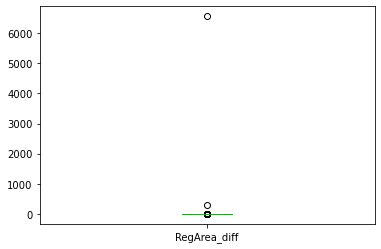

In [26]:
river_dup_RegAreariver_gp["RegArea_diff"].plot.box()

In [27]:
# 製作 比對字典 key: FullLandNo, value:RegArea_min
river_match_dict = pd.Series(river_dup_RegAreariver_gp.RegArea_min.values, index=river_dup_RegAreariver_gp.FullLandNo).to_dict()
# river_match_dict

# 比對邏輯

## 比對 new_match_dict

In [28]:
# old_df[mask_OK] v.s. new_match_dict
old_df.loc[mask_OK ,"is_FullLandNo_match_new"] = old_df.loc[mask_OK ,"FullLandNo"].isin(list(new_match_dict.keys()))
old_df.loc[mask_OK ,"new_RegArea"] = old_df.loc[mask_OK ,"FullLandNo"].map(new_match_dict)
print(f">> old(OK) FullLandNo 能對應到 new 的數量:\n{old_df['is_FullLandNo_match_new'].value_counts()}\n")

>> old(OK) FullLandNo 能對應到 new 的數量:
True     575100
False    226799
Name: is_FullLandNo_match_new, dtype: int64



In [29]:
# 計算RegArea差距，判斷 old RegArea 是否 大於 new RegArea
old_df.loc[mask_OK ,"diff_RegArea_old_minus_new"] = old_df.loc[mask_OK ,"RegArea"] - old_df.loc[mask_OK ,"new_RegArea"]
old_df.loc[mask_OK ,"is_RegArea_old_gt_new"] = old_df.loc[mask_OK ,"RegArea"] > old_df.loc[mask_OK ,"new_RegArea"]
print(f">> diff_RegArea_old describe:\n{old_df['diff_RegArea_old_minus_new'].describe()}\n")
print(f">> is_RegArea_old_gt_new :\n{old_df['is_RegArea_old_gt_new'].value_counts()}\n") #1618筆  old有比對到但是面積比new大

>> diff_RegArea_old describe:
count    575100.000000
mean         -0.104518
std           2.455411
min        -257.199800
25%          -0.000100
50%           0.000000
75%           0.000000
max           4.441900
Name: diff_RegArea_old_minus_new, dtype: float64

>> is_RegArea_old_gt_new :
False    800281
True       1618
Name: is_RegArea_old_gt_new, dtype: int64



<AxesSubplot:>

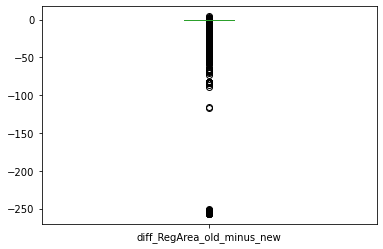

In [30]:
old_df['diff_RegArea_old_minus_new'].plot.box()

## 比對 river_match_dict

In [32]:
# old_df[mask_OK] v.s. river_match_dict
old_df.loc[mask_OK ,"is_FullLandNo_match_river"] = old_df.loc[mask_OK ,"FullLandNo"].isin(list(river_match_dict.keys()))
old_df.loc[mask_OK ,"river_RegArea"] = old_df.loc[mask_OK ,"FullLandNo"].map(river_match_dict)
print(f">> old(OK) FullLandNo 能對應到 river 的數量:\n{old_df['is_FullLandNo_match_river'].value_counts()}\n")

>> old(OK) FullLandNo 能對應到 river 的數量:
False    799564
True       2335
Name: is_FullLandNo_match_river, dtype: int64



In [33]:
# 計算RegArea差距，判斷 old RegArea 是否 大於 river RegArea
old_df.loc[mask_OK ,"diff_RegArea_old_minus_river"] = old_df.loc[mask_OK ,"RegArea"] - old_df.loc[mask_OK ,"river_RegArea"]
old_df.loc[mask_OK ,"is_RegArea_old_gt_river"] = old_df.loc[mask_OK ,"RegArea"] > old_df.loc[mask_OK ,"river_RegArea"]
print(f">> diff_RegArea_old describe:\n{old_df['diff_RegArea_old_minus_river'].describe()}\n")
print(f">> is_RegArea_old_gt_river :\n{old_df['is_RegArea_old_gt_river'].value_counts()}\n") #1307筆  old有比對到但是面積比river大

>> diff_RegArea_old describe:
count    2335.000000
mean        0.148484
std         0.443119
min        -2.422000
25%         0.000000
50%         0.003900
75%         0.109850
max         4.876900
Name: diff_RegArea_old_minus_river, dtype: float64

>> is_RegArea_old_gt_river :
False    800592
True       1307
Name: is_RegArea_old_gt_river, dtype: int64



<AxesSubplot:>

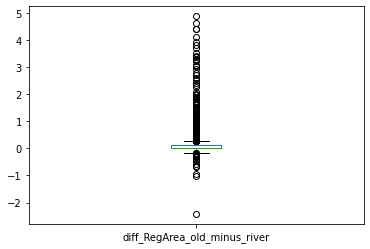

In [34]:
old_df['diff_RegArea_old_minus_river'].plot.box()

## 彙總

In [55]:
# 邏輯欄位 缺值狀況
old_df.isnull().sum()

欄位1                                  3
欄位2                                  3
欄位3                                  3
FarmerIDCardNo                       0
CountyName                           3
TownshipName                         3
TownshipCode                         6
CountyCode                           3
Section                              3
Code                                 3
LandNo                               3
RegArea_org                          3
FullLandNo                           3
CreateDate                           3
UpdateDate                           3
UserIP                           23159
IsDel                                6
CropTypeNm                           6
is_FullLandNo_pattern_farm           3
is_FullLandNo_pattern_river          3
is_FullLandNo_pattern_OK             0
RegArea                              6
is_RegArea_OK                        0
is_FullLandNo_match_new            329
new_RegArea                     227128
diff_RegArea_old_minus_ne

In [58]:
old_df[13174:13176]

,欄位1,欄位2,欄位3,FarmerIDCardNo,CountyName,TownshipName,TownshipCode,CountyCode,Section,Code,...,is_RegArea_OK,is_FullLandNo_match_new,new_RegArea,diff_RegArea_old_minus_new,is_RegArea_old_gt_new,is_FullLandNo_match_river,river_RegArea,diff_RegArea_old_minus_river,is_RegArea_old_gt_river,_idx
13174,NaN,NaN,NaN,11,B,武陵,NaN,3654,00820000,BE365400820000,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13174
13175,17576.0,1.0,760.0,L121398729,臺中市,大甲區,11.0,B,武陵,3654,...,True,False,NaN,NaN,False,False,NaN,NaN,False,13175


In [65]:
# 針對 邏輯欄位缺值 補 False
old_df.loc[:,[c for c in old_df.columns if "is" in c]] = old_df.loc[:,[c for c in old_df.columns if "is" in c]].fillna(False)

## 邏輯欄位說明

|編號|名稱|說明|
|:---|:---|:---|
|1. |is_FullLandNo_pattern_farm |判斷old FullLandNo 的格式 是否符合 農地籍規則|
|2. |is_FullLandNo_pattern_river| 判斷old FullLandNo 的格式 是否符合 河川地籍規則|
|3. |is_FullLandNo_pattern_OK|判斷old FullLandNo 的格式 是否符合 農地籍 **或** 河川地籍 規則|
|4. |is_RegArea_OK|判斷old RegArea 的格式 是否為 浮點數格式|
|5. |is_FullLandNo_match_new|判斷old FullLandNo (前提條件:3、4為True) 是否能在 new 資料中找到相同的FullLandNo|
|6. |is_RegArea_old_gt_new|判斷old RegArea  是否**大於**  new 資料中對應的RegArea (old前提條件:3、4為True)|
|7. |is_FullLandNo_match_river|判斷old FullLandNo  是否能在 river 資料中找到相同的FullLandNo (old前提條件:3、4為True)|
|8. |is_RegArea_old_gt_river|判斷old RegArea  是否**大於**  river 資料中對應的RegArea (old前提條件:3、4為True)|

In [66]:
# 邏輯欄位 缺值狀況
old_df.isnull().sum()

欄位1                                  3
欄位2                                  3
欄位3                                  3
FarmerIDCardNo                       0
CountyName                           3
TownshipName                         3
TownshipCode                         6
CountyCode                           3
Section                              3
Code                                 3
LandNo                               3
RegArea_org                          3
FullLandNo                           3
CreateDate                           3
UpdateDate                           3
UserIP                           23159
IsDel                                6
CropTypeNm                           6
is_FullLandNo_pattern_farm           0
is_FullLandNo_pattern_river          0
is_FullLandNo_pattern_OK             0
RegArea                              6
is_RegArea_OK                        0
is_FullLandNo_match_new              0
new_RegArea                     227128
diff_RegArea_old_minus_ne

# 結果匯出

In [44]:
old_df.head()

,欄位1,欄位2,欄位3,FarmerIDCardNo,CountyName,TownshipName,TownshipCode,CountyCode,Section,Code,...,RegArea,is_RegArea_OK,is_FullLandNo_match_new,new_RegArea,diff_RegArea_old_minus_new,is_RegArea_old_gt_new,is_FullLandNo_match_river,river_RegArea,diff_RegArea_old_minus_river,is_RegArea_old_gt_river
0,744399.0,4.0,2554.0,p121462147,雲林縣,東勢鄉,14.0,P,西安,1108,...,0.2610,True,True,0.2613,-0.0003,False,False,NaN,NaN,False
1,744400.0,1.0,1907.0,F226747855,彰化縣,和美鎮,3.0,N,犁盛,0296,...,0.1940,True,True,0.1940,0.0000,False,False,NaN,NaN,False
2,744401.0,5.0,537.0,s121986369,高雄市,六龜區,32.0,E,新發,3615,...,0.1451,True,True,0.1452,-0.0001,False,False,NaN,NaN,False
3,744402.0,5.0,537.0,s121986369,高雄市,六龜區,32.0,E,新發,3615,...,0.1630,True,True,0.1631,-0.0001,False,False,NaN,NaN,False
4,744403.0,4.0,1961.0,s121915075,高雄市,美濃區,31.0,E,龍肚,3511,...,0.1700,True,True,0.1700,0.0000,False,False,NaN,NaN,False


In [46]:
formtoXlsx(old_df, "大冠比對結果V1") # 輸出請耐心等待

 ==輸出備份xlsx== ::: 大冠比對結果V1_20210604_16.33.52.xlsx
